# Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

In [2]:
seed = 29
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import os
import pandas as pd

def collect_paths(split_dir):
    data = []
    base_dir = Path("LungTumorDetectionAndSegmentation") / split_dir
    images_root = os.path.join(base_dir, 'images')
    masks_root = os.path.join(base_dir, 'masks')
    dets_root = os.path.join(base_dir, 'detections')

    for subject in os.listdir(images_root):
        subject_img_dir = os.path.join(images_root, subject)
        subject_mask_dir = os.path.join(masks_root, subject)
        subject_det_dir = os.path.join(dets_root, subject)

        for det_file in os.listdir(subject_det_dir):
            if det_file.endswith('.txt'):
                img_name = det_file.replace('.txt', '.png')
                image_path = os.path.join(subject_img_dir, img_name)
                mask_path = os.path.join(subject_mask_dir, img_name)
                det_path = os.path.join(subject_det_dir, det_file)

                data.append({
                    'image_path': image_path,
                    'mask_path': mask_path,
                    'detection_path': det_path
                })

    return pd.DataFrame(data)

# Build DataFrames for train and val
train_df = collect_paths("train")
val_df = collect_paths("val")


# Functions

In [5]:
def get_bbox_from_file(file_path):
    """Read bounding boxes from a .txt file."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    bboxes = [list(map(int, line.strip().split(','))) for line in lines]
    return bboxes

In [6]:
def smart_crop(image, bbox, target_size=(64,64), padding_ratio=0.15, is_mask=False):
    """
    Smart cropping function that handles edge cases and ensures consistent output size.
    
    Args:
        image: Input image (numpy array)
        bbox: Bounding box [xmin, ymin, xmax, ymax]
        target_size: Final crop size (int or tuple)
        padding_ratio: Extra padding around bbox (0.15 = 15% padding)
        is_mask: If True, uses nearest neighbor interpolation for masks
        
    Returns:
        tuple: (cropped_resized_image, mapping_info)
        mapping_info contains:
        - crop_coords: actual coordinates used for cropping [x1, y1, x2, y2]
        - scale_x, scale_y: scaling factors from crop to target_size
        - original_crop_size: size of crop before resizing
    """

    
    h_img, w_img = image.shape[:2]
    xmin, ymin, xmax, ymax = bbox
    
    # Calculate original bbox dimensions
    orig_w = xmax - xmin
    orig_h = ymax - ymin
    
    # Skip invalid bboxes
    if orig_w <= 0 or orig_h <= 0:
        raise ValueError("Invalid bounding box dimensions.")
  
    
    # Add padding
    padding_x = int(padding_ratio * orig_w)
    padding_y = int(padding_ratio * orig_h)
    
    # Expand bbox with padding
    xmin = max(0, xmin - padding_x)
    xmax = min(w_img, xmax + padding_x)
    ymin = max(0, ymin - padding_y)
    ymax = min(h_img, ymax + padding_y)
    orig_w = xmax - xmin
    orig_h = ymax - ymin
    
    if orig_w <= 0 or orig_h <= 0:
        pass
    
    # For very small tumors, expand context while preserving tumor location
    if orig_w < 32 or orig_h < 32:

        center_x = (xmin + xmax) // 2
        center_y = (ymin + ymax) // 2
        
        # Expand to minimum 32x32 with context
        expand_size = 32
        expand_w = max(expand_size, orig_w)
        expand_h = max(expand_size, orig_h)
        new_xmin = max(0, center_x - expand_w//2)
        new_xmax = min(w_img, center_x + expand_w//2)
        new_ymin = max(0, center_y - expand_h//2)
        new_ymax = min(h_img, center_y + expand_h//2)
        
        # Adjust if we hit image boundaries
        if new_xmax - new_xmin < expand_size:
            new_xmax = new_xmin + expand_size
            if new_xmax > w_img:
                new_xmax = w_img
                new_xmin = w_img - expand_size

        if new_ymax - new_ymin < expand_size:
            new_ymax = new_ymin + expand_size
            if new_ymax > h_img:
                new_ymax = h_img
                new_ymin = h_img - expand_size
                
        xmin, ymin, xmax, ymax = new_xmin, new_ymin, new_xmax, new_ymax

    cropped = image[ymin:ymax, xmin:xmax]

    if cropped.size == 0:
        pass

    # Resize to target size
    if is_mask:
        # Use nearest neighbor for masks to preserve label values
        resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_NEAREST)
    else:
        # Use bilinear for images
        resized = cv2.resize(cropped, target_size)
    
    # Calculate mapping information
    mapping_info = {
        'crop_coords': [xmin, ymin, xmax, ymax],
        'original_crop_size': (orig_w, orig_h),
        'target_size': target_size,
        'original_bbox': bbox
    }
    
    return resized, mapping_info

In [7]:
train_set = []
for _,row in train_df.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']
    det_path = row['detection_path']

    bboxes=get_bbox_from_file(det_path)
    for bbox in bboxes:
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Smart crop the image and mask
        cropped_image, mapping_info_image = smart_crop(image, bbox, target_size=(64, 64), is_mask=False)
        cropped_mask, mapping_info_mask = smart_crop(mask, bbox, target_size=(64, 64), is_mask=True)
        train_set.append({
            'image': image,
            'cropped_image': cropped_image,
            **mapping_info_image,
            'mask': cropped_mask,
        })


In [8]:
train_dataframe = pd.DataFrame(train_set)

In [9]:
val_set = []
for _,row in val_df.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']
    det_path = row['detection_path']

    bboxes=get_bbox_from_file(det_path)
    for bbox in bboxes:
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Smart crop the image and mask
        cropped_image, mapping_info_image = smart_crop(image, bbox, target_size=(64, 64), is_mask=False)
        cropped_mask, mapping_info_mask = smart_crop(mask, bbox, target_size=(64, 64), is_mask=True)
        val_set.append({
            'image': image,
            'cropped_image': cropped_image,
            **mapping_info_image,
            'mask': cropped_mask,
        })

val_dataframe = pd.DataFrame(val_set)

# Dataset Class

In [11]:
class TumorDatasetFromDataFrame(Dataset):
    def __init__(self, dataframe, augment=True):
        self.df = dataframe.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(row["cropped_image"]).astype(np.float32) / 255.0
        mask = np.array(row["mask"]).astype(np.float32)
        mask = (mask > 0).astype(np.float32)  # Ensure binary

        # Optional metadata (if needed for size-based aug)
        orig_crop_size = row.get("original_crop_size", (64, 64))
        crop_coords = row.get("crop_coords", [0, 0, 64, 64])
        
        # Apply augmentation if enabled
        if self.augment:
            image, mask = self.apply_synchronized_transforms(image, mask, orig_crop_size)

        # CHW format for PyTorch
        image = np.transpose(image, (2, 0, 1))  # HWC → CHW

        return {
            "image": torch.tensor(image, dtype=torch.float32),
            "mask": torch.tensor(mask, dtype=torch.float32).unsqueeze(0),
            "original_image": row["image"],  # Original image for reference
            "orig_size": orig_crop_size,
            "crop_coords": crop_coords
        }

    def apply_synchronized_transforms(self, image_np, mask_np, orig_size):
        """Apply size-aware augmentation (flip, rotate, jitter)"""
        image = TF.to_pil_image(image_np)
        mask = TF.to_pil_image(mask_np)

        max_size = max(orig_size)
        if max_size < 8:
            flip_prob, rot_deg, jitter = 0.2, 0, 0.05
        elif max_size < 16:
            flip_prob, rot_deg, jitter = 0.4, 5, 0.1
        else:
            flip_prob, rot_deg, jitter = 0.5, 15, 0.2

        if random.random() < flip_prob:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if random.random() < flip_prob:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        if rot_deg > 0:
            angle = random.uniform(-rot_deg, rot_deg)
            image = TF.rotate(image, angle, fill=0)
            mask = TF.rotate(mask, angle, fill=0)

        if jitter > 0:
            jitter_transform = transforms.ColorJitter(
                brightness=jitter, contrast=jitter, saturation=jitter
            )
            image = jitter_transform(image)

        # Convert back to NumPy
        image_np = np.array(image).astype(np.float32) / 255.0
        mask_np = (np.array(mask) > 0).astype(np.float32)
        return image_np, mask_np


# U-Net

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [13]:

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Downsampling path (encoder)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(features[-1], features[-1] * 2),
            nn.Dropout2d(0.3)  # or 0.5 if you want stronger regularization
        )
        # Upsampling path (decoder)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # transpose conv
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)


# Training + Validation Functions

In [14]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0
    for batch in loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        # Forward pass
        preds = model(images)
        loss = loss_fn(preds, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss / len(loader)

In [15]:
def evaluate(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [16]:
class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.4, dice_weight=0.6, smooth=1):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.smooth = smooth

    def forward(self, inputs, targets):
        # BCE loss
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        # Dice loss
        inputs_sig = torch.sigmoid(inputs)       
        inputs_flat = inputs_sig.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()                            
        dice = (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)  
        dice_loss = 1 - dice
        
        return self.bce_weight * bce + self.dice_weight * dice_loss

In [17]:
def calculate_metrics(model, loader, device):
    """Calculate comprehensive metrics"""
    model.eval()
    total_iou = 0
    total_dice = 0
    total_pixel_acc = 0
    num_samples = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            
            preds = torch.sigmoid(model(images))
            preds_binary = (preds > 0.5).float()
            
            # Flatten for calculations
            pred_flat = preds_binary.view(preds.size(0), -1)
            mask_flat = masks.view(masks.size(0), -1)
            
            for i in range(pred_flat.size(0)):
                pred_i = pred_flat[i]
                mask_i = mask_flat[i]
                
                # Pixel accuracy
                pixel_acc = (pred_i == mask_i).float().mean().item()
                
                # IoU (Jaccard Index)
                intersection = (pred_i * mask_i).sum().item()
                union = pred_i.sum().item() + mask_i.sum().item() - intersection
                iou = intersection / (union + 1e-8)
                
                # Dice coefficient
                dice = (2 * intersection) / (pred_i.sum().item() + mask_i.sum().item() + 1e-8)
                
                total_pixel_acc += pixel_acc
                total_iou += iou
                total_dice += dice
                num_samples += 1
    
    return {
        'accuracy': total_pixel_acc / num_samples,
        'iou': total_iou / num_samples,
        'dice': total_dice / num_samples
    }

# Training Stage

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
loss_fn = DiceBCELoss()  # sigmoid inside loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [19]:
train_dataset = TumorDatasetFromDataFrame(train_dataframe, augment=True)
val_full_dataset = TumorDatasetFromDataFrame(val_dataframe, augment=False)

In [20]:
val_size = int(0.7 * len(val_full_dataset))
test_size = len(val_full_dataset) - val_size
val_dataset, test_dataset = random_split(val_full_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(42))

In [21]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1677
Validation dataset size: 60
Test dataset size: 26


In [22]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [23]:
epochs = 50
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_pixel_accs = []
val_ious = []
val_dices = []

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = evaluate(model, val_loader, loss_fn, device)
    val_metrics = calculate_metrics(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_pixel_accs.append(val_metrics['accuracy'])
    val_ious.append(val_metrics['iou'])
    val_dices.append(val_metrics['dice'])
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Metrics - Pixel Acc: {val_metrics['accuracy']:.4f}, IoU: {val_metrics['iou']:.4f}, Dice: {val_metrics['dice']:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet_cropped.pth")
        print(f"New best model saved with val loss: {val_loss:.4f}")
    print("--------------------------------------------------")

Epoch 1/50 | Train Loss: 0.5121 | Val Loss: 0.5493
Val Metrics - Pixel Acc: 0.9344, IoU: 0.4897, Dice: 0.6173
New best model saved with val loss: 0.5493
--------------------------------------------------
Epoch 2/50 | Train Loss: 0.4265 | Val Loss: 0.4955
Val Metrics - Pixel Acc: 0.9450, IoU: 0.5575, Dice: 0.6887
New best model saved with val loss: 0.4955
--------------------------------------------------
Epoch 3/50 | Train Loss: 0.3929 | Val Loss: 0.4968
Val Metrics - Pixel Acc: 0.9354, IoU: 0.4988, Dice: 0.6268
--------------------------------------------------
Epoch 4/50 | Train Loss: 0.3674 | Val Loss: 0.4507
Val Metrics - Pixel Acc: 0.9357, IoU: 0.5323, Dice: 0.6632
New best model saved with val loss: 0.4507
--------------------------------------------------
Epoch 5/50 | Train Loss: 0.3462 | Val Loss: 0.4223
Val Metrics - Pixel Acc: 0.9416, IoU: 0.5493, Dice: 0.6771
New best model saved with val loss: 0.4223
--------------------------------------------------
Epoch 6/50 | Train Loss

In [24]:
model.load_state_dict(torch.load("best_unet_cropped.pth", weights_only=False))
test_metrics = calculate_metrics(model, test_loader, device)
print(f"Test set metrics: Pixel Acc: {test_metrics['accuracy']:.4f}, IoU: {test_metrics['iou']:.4f}, Dice: {test_metrics['dice']:.4f}")

Test set metrics: Pixel Acc: 0.9619, IoU: 0.7088, Dice: 0.8226



Calculating final metrics...

Final Results:
Train - Pixel Acc: 0.9638, IoU: 0.7719, Dice: 0.8599
Val   - Pixel Acc: 0.9521, IoU: 0.6052, Dice: 0.7136
Test  - Pixel Acc: 0.9619, IoU: 0.7088, Dice: 0.8226


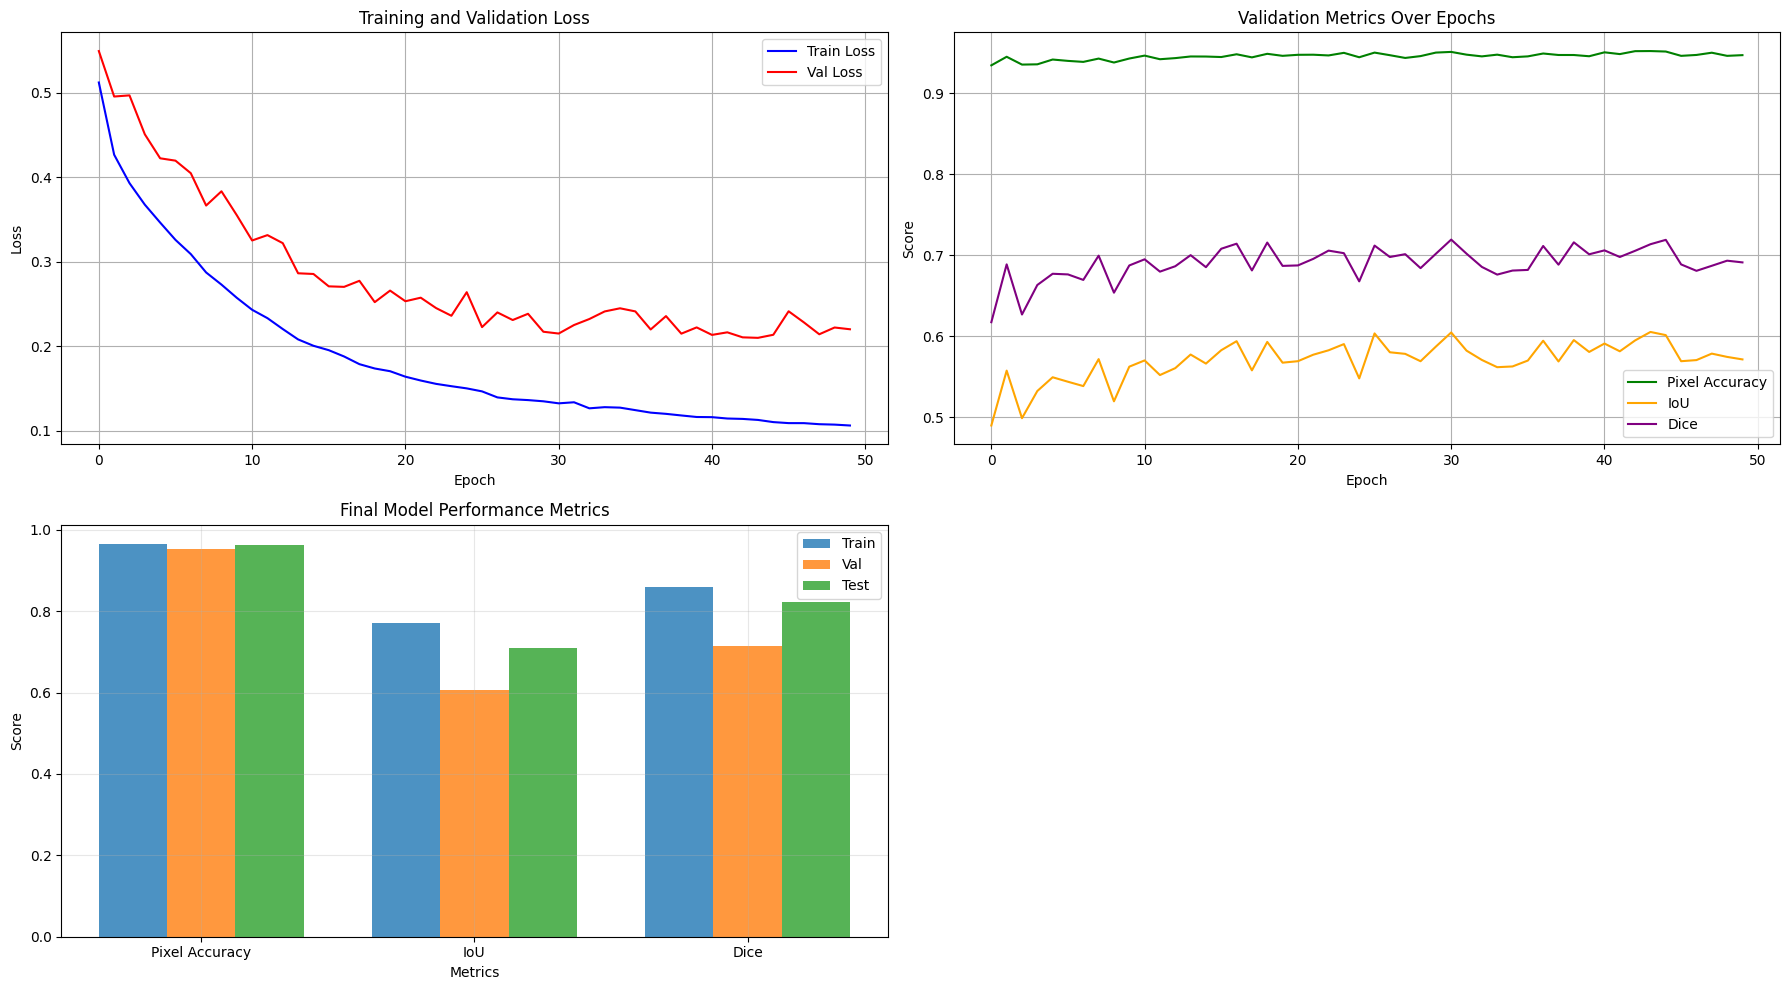

In [25]:
plt.figure(figsize=(18, 10))

# ---------------------- LOSS PLOT ----------------------
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# ---------------------- METRIC BAR PLOT ----------------------
# Calculate and display final metrics
print("\nCalculating final metrics...")
train_metrics = calculate_metrics(model, train_loader, device)
val_metrics = calculate_metrics(model, val_loader, device)
test_metrics = calculate_metrics(model, test_loader, device)

print("\nFinal Results:")
print(f"Train - Pixel Acc: {train_metrics['accuracy']:.4f}, IoU: {train_metrics['iou']:.4f}, Dice: {train_metrics['dice']:.4f}")
print(f"Val   - Pixel Acc: {val_metrics['accuracy']:.4f}, IoU: {val_metrics['iou']:.4f}, Dice: {val_metrics['dice']:.4f}")
print(f"Test  - Pixel Acc: {test_metrics['accuracy']:.4f}, IoU: {test_metrics['iou']:.4f}, Dice: {test_metrics['dice']:.4f}")

plt.subplot(2, 2, 3)
metrics_names = ['Pixel Accuracy', 'IoU', 'Dice']
train_vals = [train_metrics['accuracy'], train_metrics['iou'], train_metrics['dice']]
val_vals = [val_metrics['accuracy'], val_metrics['iou'], val_metrics['dice']]
test_vals = [test_metrics['accuracy'], test_metrics['iou'], test_metrics['dice']]

x = np.arange(len(metrics_names))
width = 0.25

plt.bar(x - width, train_vals, width, label='Train', alpha=0.8)
plt.bar(x, val_vals, width, label='Val', alpha=0.8)
plt.bar(x + width, test_vals, width, label='Test', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Final Model Performance Metrics')
plt.xticks(x, metrics_names)
plt.legend()
plt.grid(True, alpha=0.3)

# ---------------------- VAL METRICS OVER EPOCHS ----------------------
plt.subplot(2, 2, 2)
plt.plot(val_pixel_accs, label='Pixel Accuracy', color='green')
plt.plot(val_ious, label='IoU', color='orange')
plt.plot(val_dices, label='Dice', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Visualization

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=5, on_full_image=False):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        sample = dataset[idx]
        image_tensor = sample["image"]  # [C, H, W]
        mask = sample["mask"].squeeze().cpu().numpy()

        input_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            output = torch.sigmoid(output)
            pred = output.squeeze().cpu().numpy()
            pred_binary = (pred > 0.5).astype(np.uint8)

        if on_full_image and "original_image" in sample and "crop_coords" in sample:
            # --- Full image visualization ---
            orig_image = np.array(sample["original_image"])
            xmin, ymin, xmax, ymax = sample["crop_coords"]
            orig_w, orig_h = xmax - xmin, ymax - ymin

            # Resize predicted & ground truth masks to crop size
            pred_resized = cv2.resize(pred_binary.astype(np.uint8), (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
            gt_resized = cv2.resize(mask.astype(np.uint8), (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

            # Paste into blank full-size masks
            h_full, w_full = orig_image.shape[:2]
            pred_full = np.zeros((h_full, w_full), dtype=np.uint8)
            gt_full = np.zeros((h_full, w_full), dtype=np.uint8)
            pred_full[ymin:ymax, xmin:xmax] = pred_resized
            gt_full[ymin:ymax, xmin:xmax] = gt_resized

            # Normalize image for overlay
            img_display = orig_image.astype(np.float32)
            if img_display.max() > 1.0:
                img_display /= 255.0
            img_display = np.clip(img_display, 0, 1)

            # Create overlays
            overlay_pred = img_display.copy()
            overlay_pred[..., 0] = np.maximum(overlay_pred[..., 0], pred_full * 1.0)  # Red

            overlay_gt = img_display.copy()
            overlay_gt[..., 1] = np.maximum(overlay_gt[..., 1], gt_full * 1.0)  # Green

            fig, axes = plt.subplots(1, 4, figsize=(22, 6))
            axes[0].imshow(img_display)
            axes[0].set_title(f"Original Image\n{h_full}x{w_full}")
            axes[0].axis('off')

            axes[1].imshow(overlay_gt)
            axes[1].set_title("Ground Truth Overlay (Green)")
            axes[1].axis('off')

            axes[2].imshow(overlay_pred)
            axes[2].set_title("Prediction Overlay (Red)")
            axes[2].axis('off')

            axes[3].imshow(pred_full, cmap='gray')
            axes[3].set_title("Binary Prediction Mask")
            axes[3].axis('off')

        else:
            # --- Cropped image visualization ---
            image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-5)

            overlay_pred = image_np.copy()
            overlay_pred[..., 0] = np.maximum(overlay_pred[..., 0], pred_binary * 1.0)

            overlay_gt = image_np.copy()
            overlay_gt[..., 1] = np.maximum(overlay_gt[..., 1], mask * 1.0)

            orig_size = sample.get("orig_size", image_np.shape[:2])

            fig, axes = plt.subplots(1, 4, figsize=(20, 4))
            axes[0].imshow(image_np)
            axes[0].set_title(f"Cropped Image\n{orig_size[0]}x{orig_size[1]}")
            axes[0].axis("off")

            axes[1].imshow(overlay_gt)
            axes[1].set_title("Ground Truth Overlay (Green)")
            axes[1].axis("off")

            axes[2].imshow(overlay_pred)
            axes[2].set_title("Prediction Overlay (Red)")
            axes[2].axis("off")

            axes[3].imshow(pred_binary, cmap='gray')
            axes[3].set_title("Binary Prediction Mask")
            axes[3].axis("off")

        plt.tight_layout()
        plt.show()


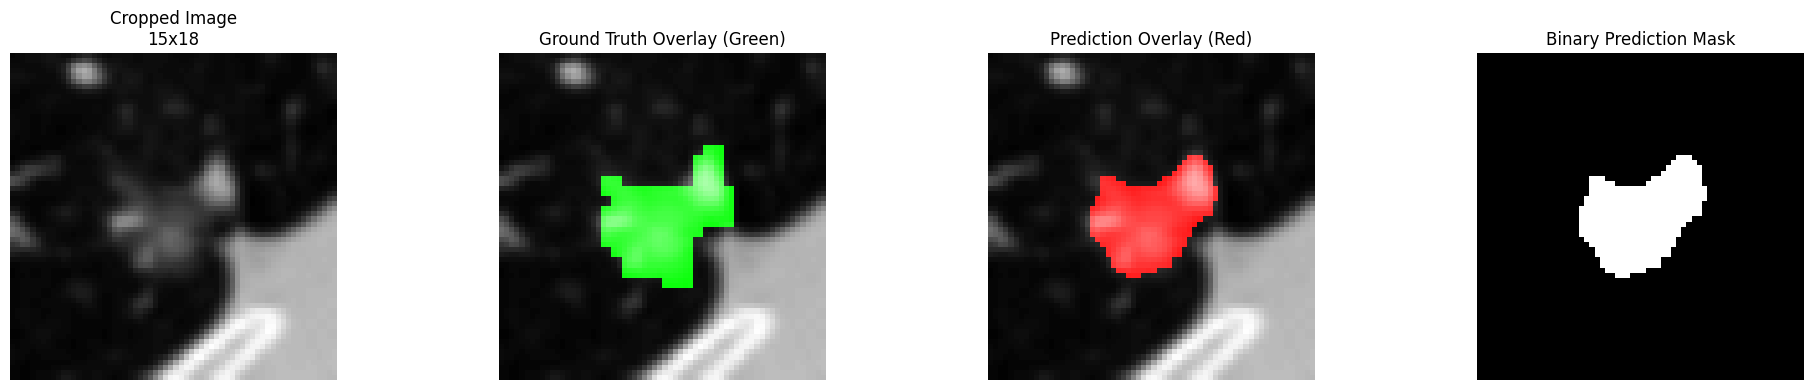

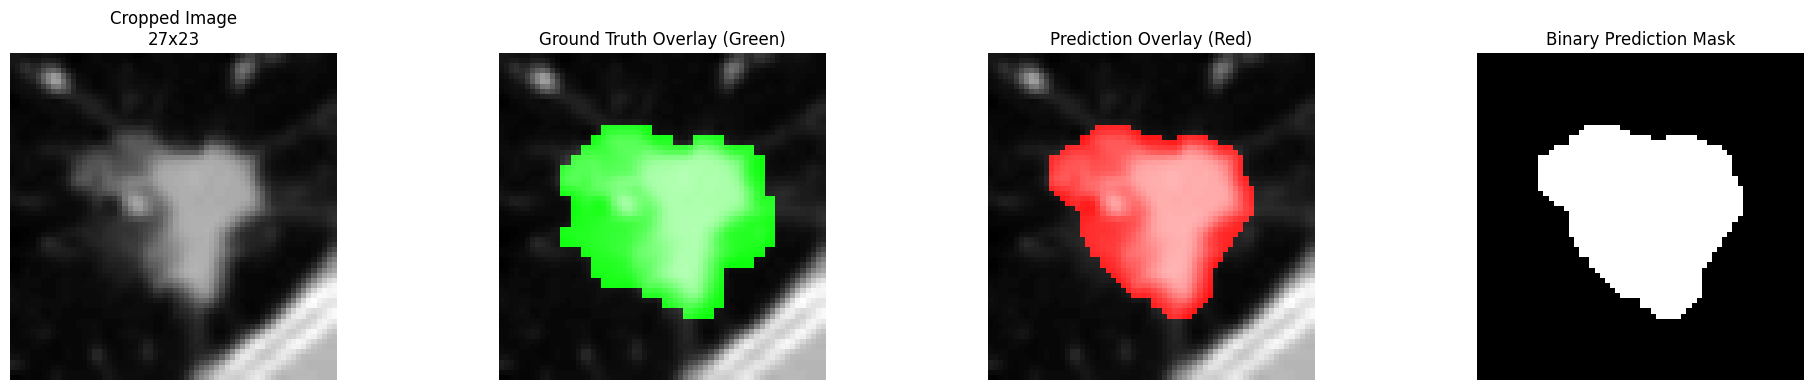

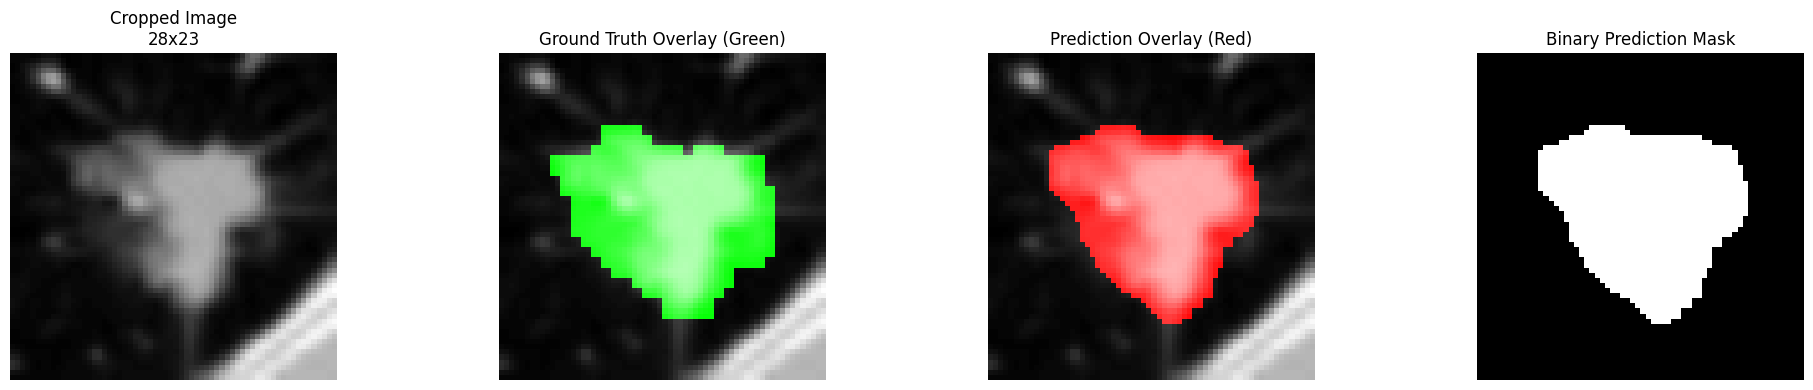

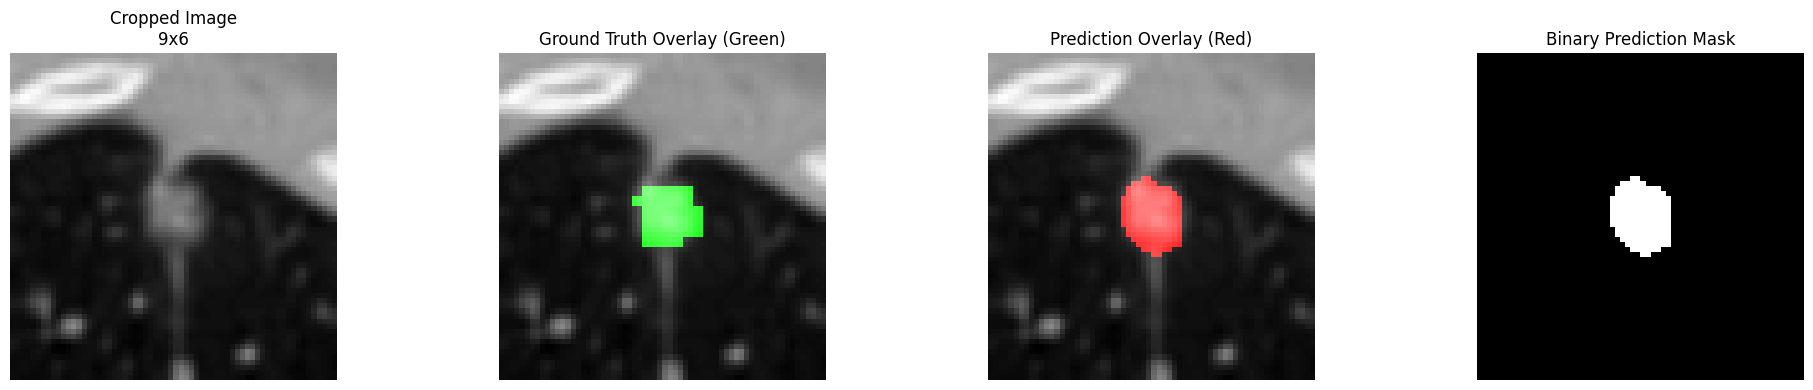

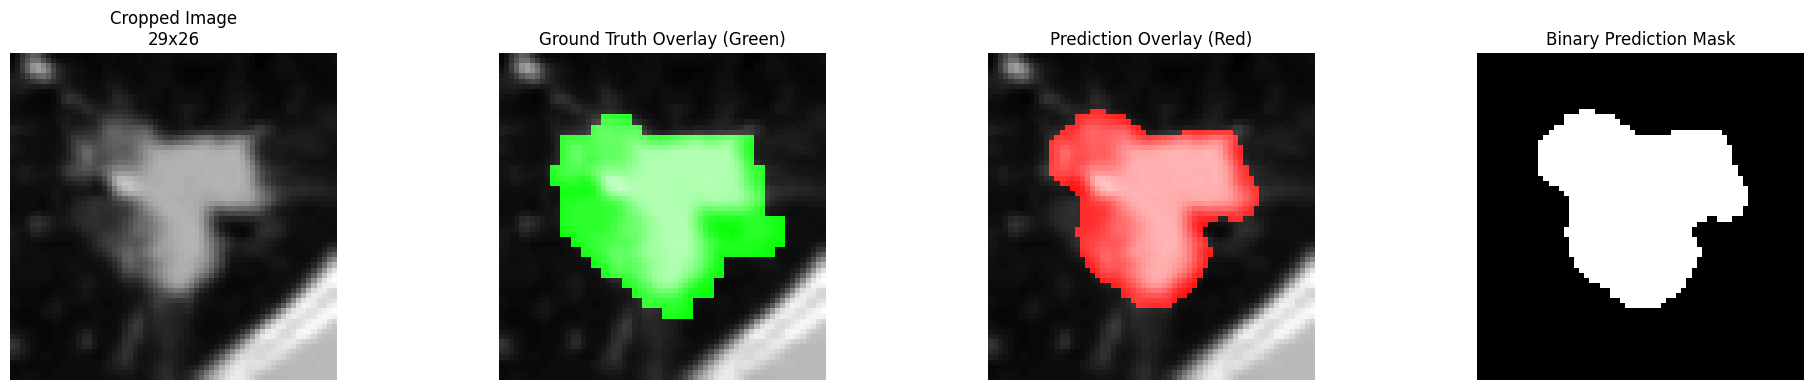

In [33]:
visualize_predictions(model, val_dataset, device, num_samples=5, on_full_image=False)

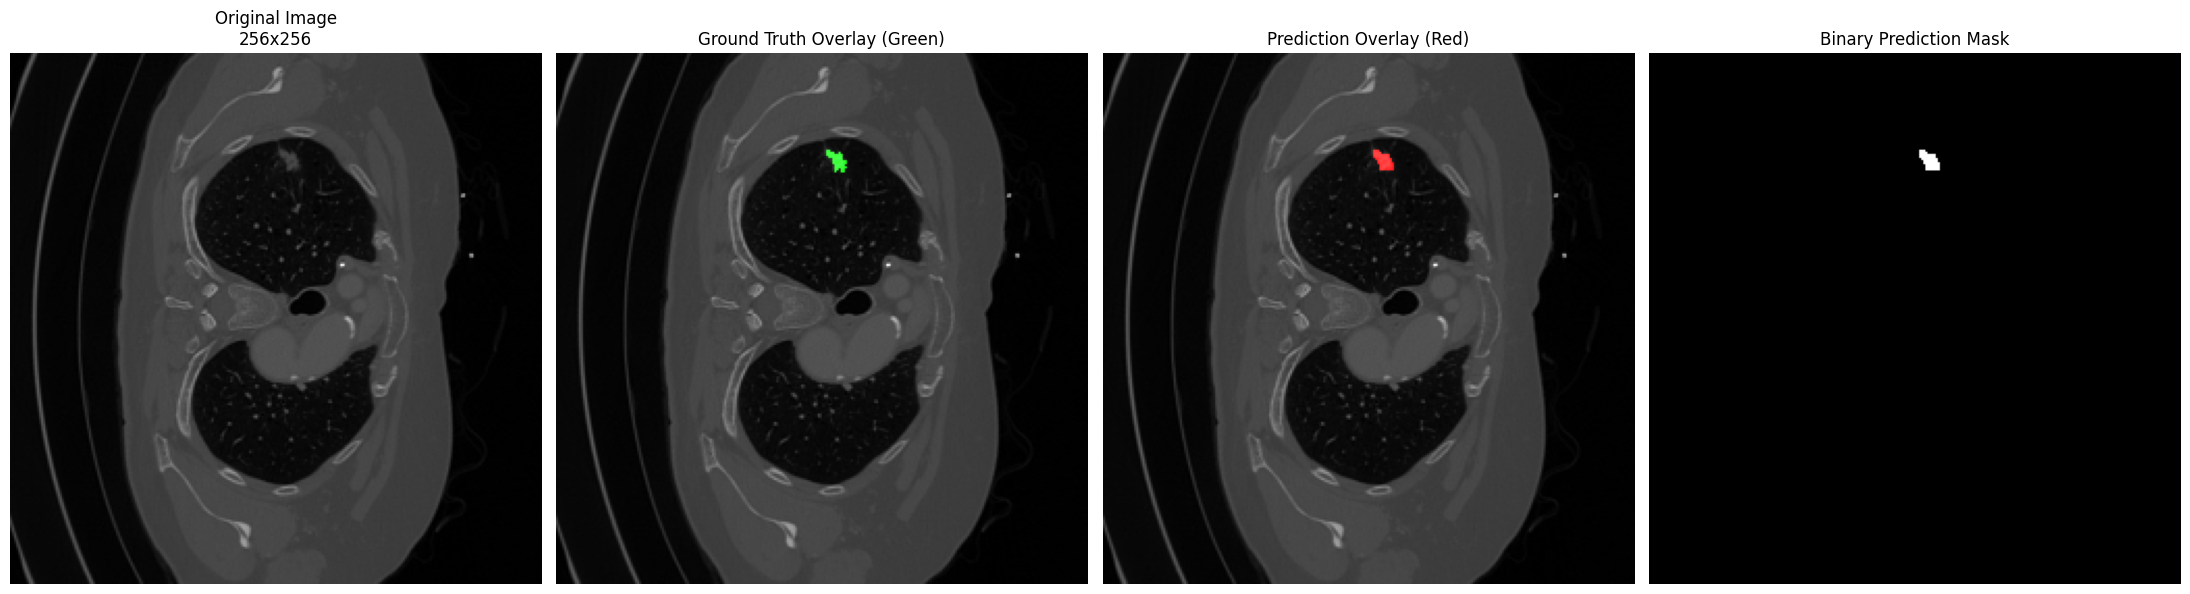

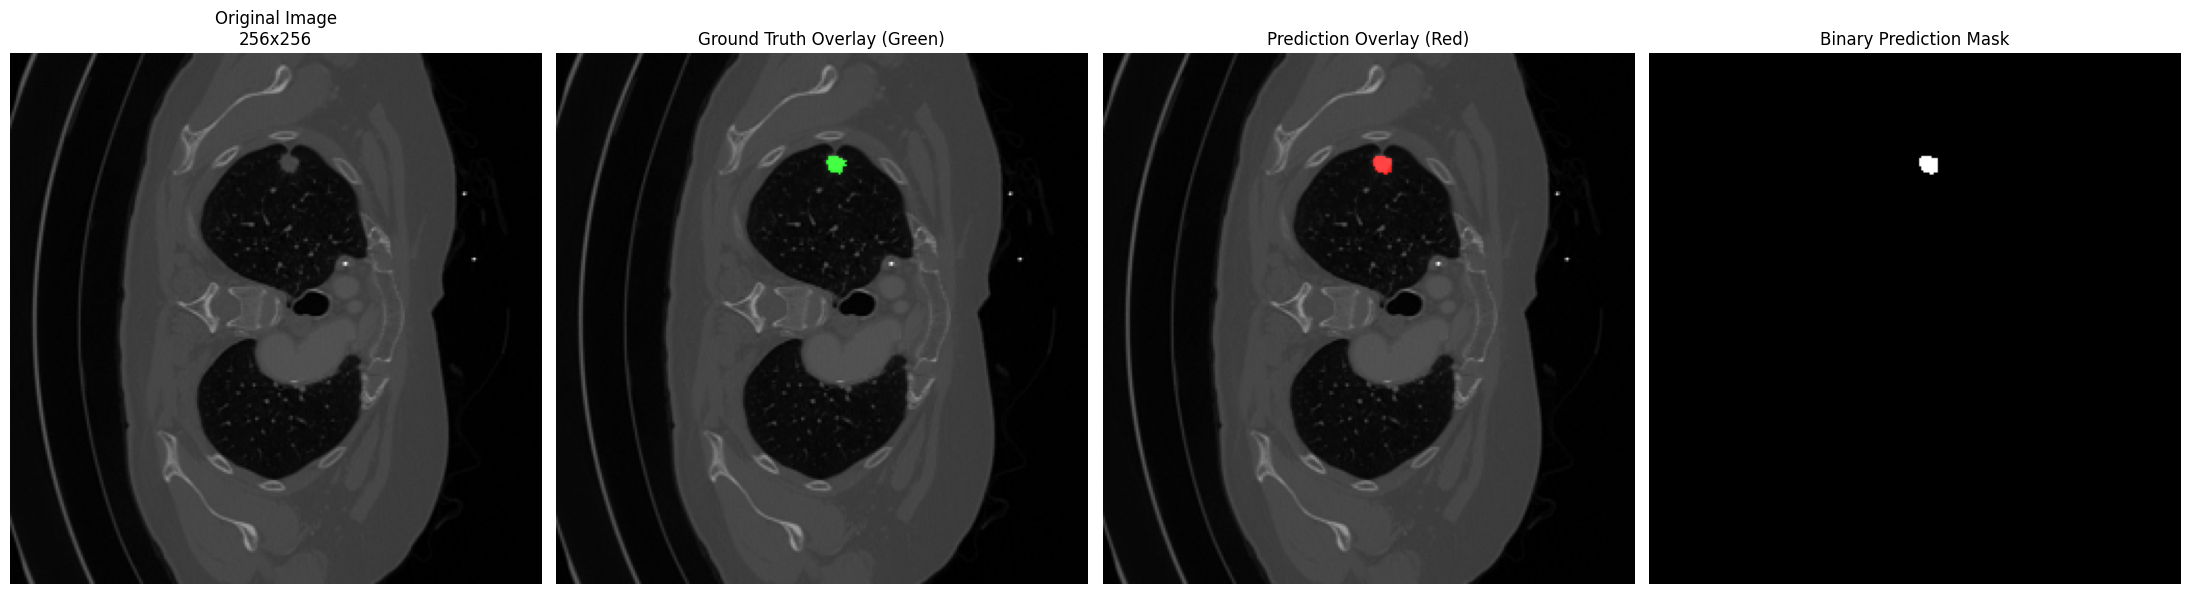

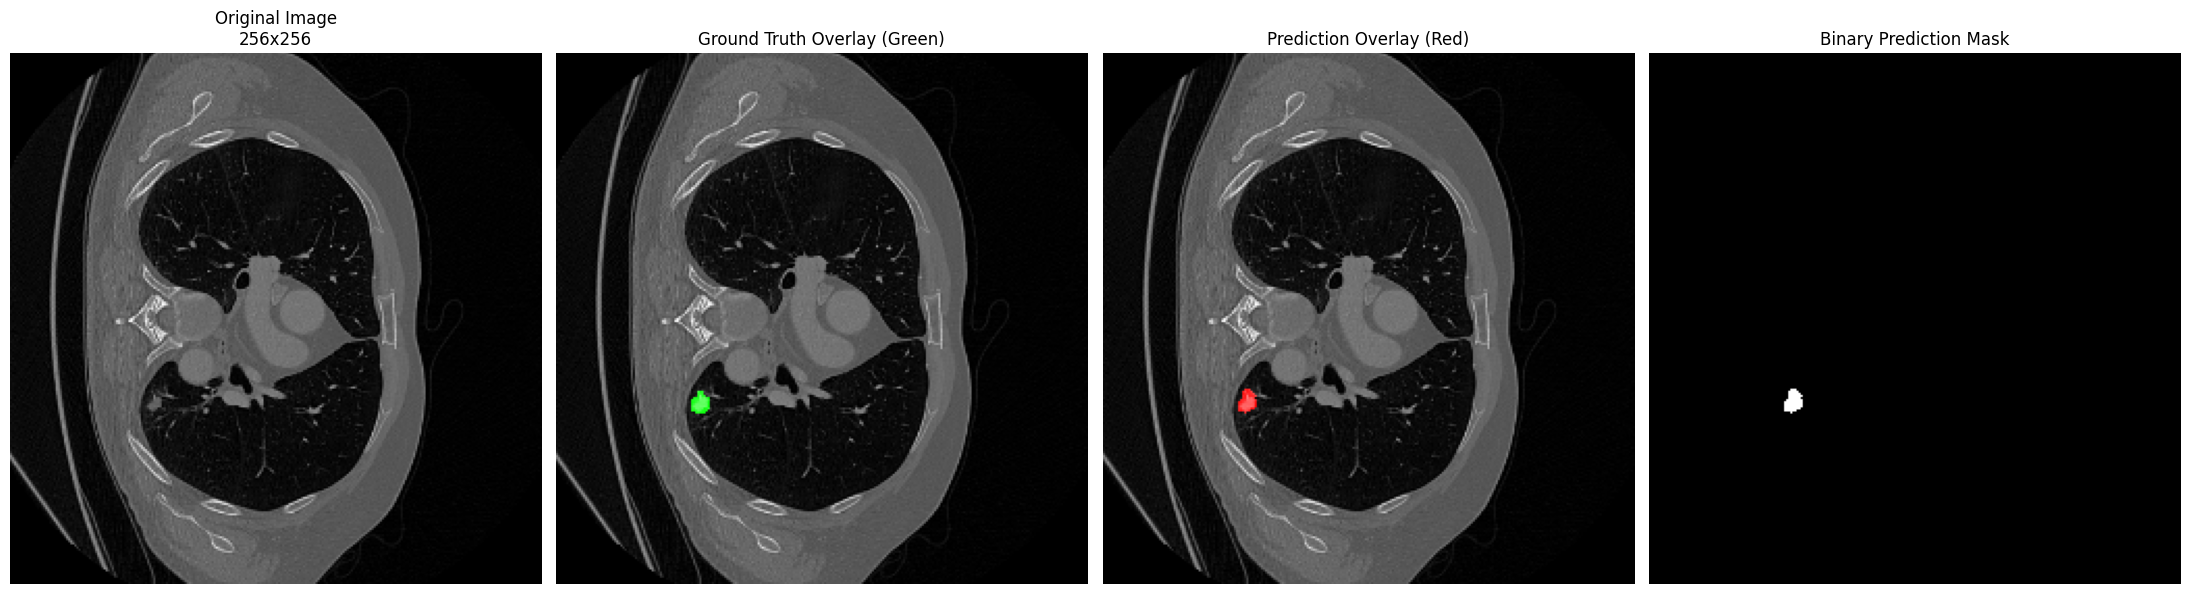

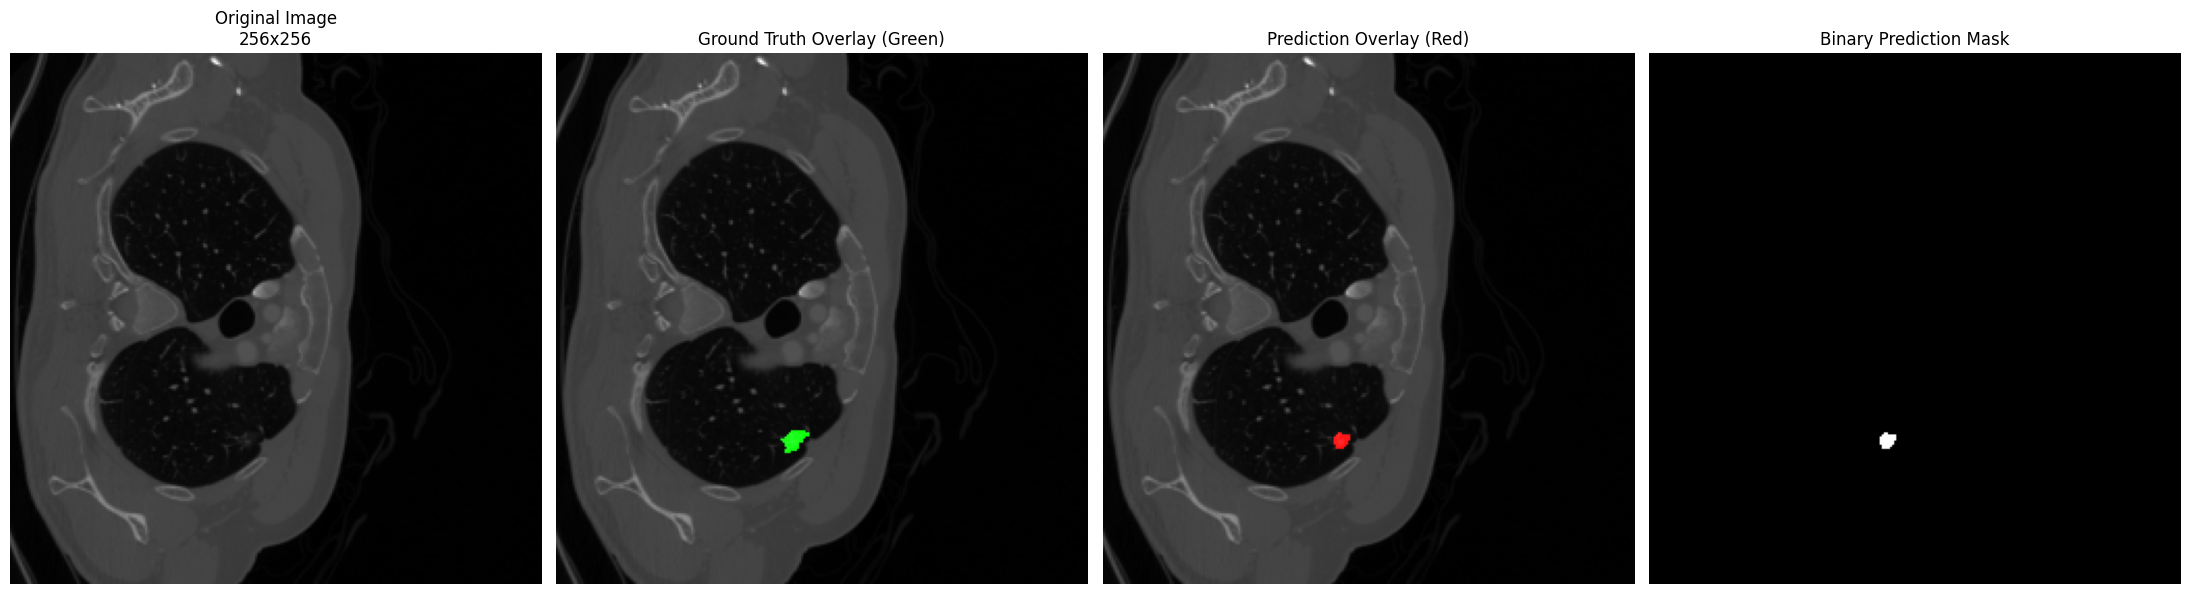

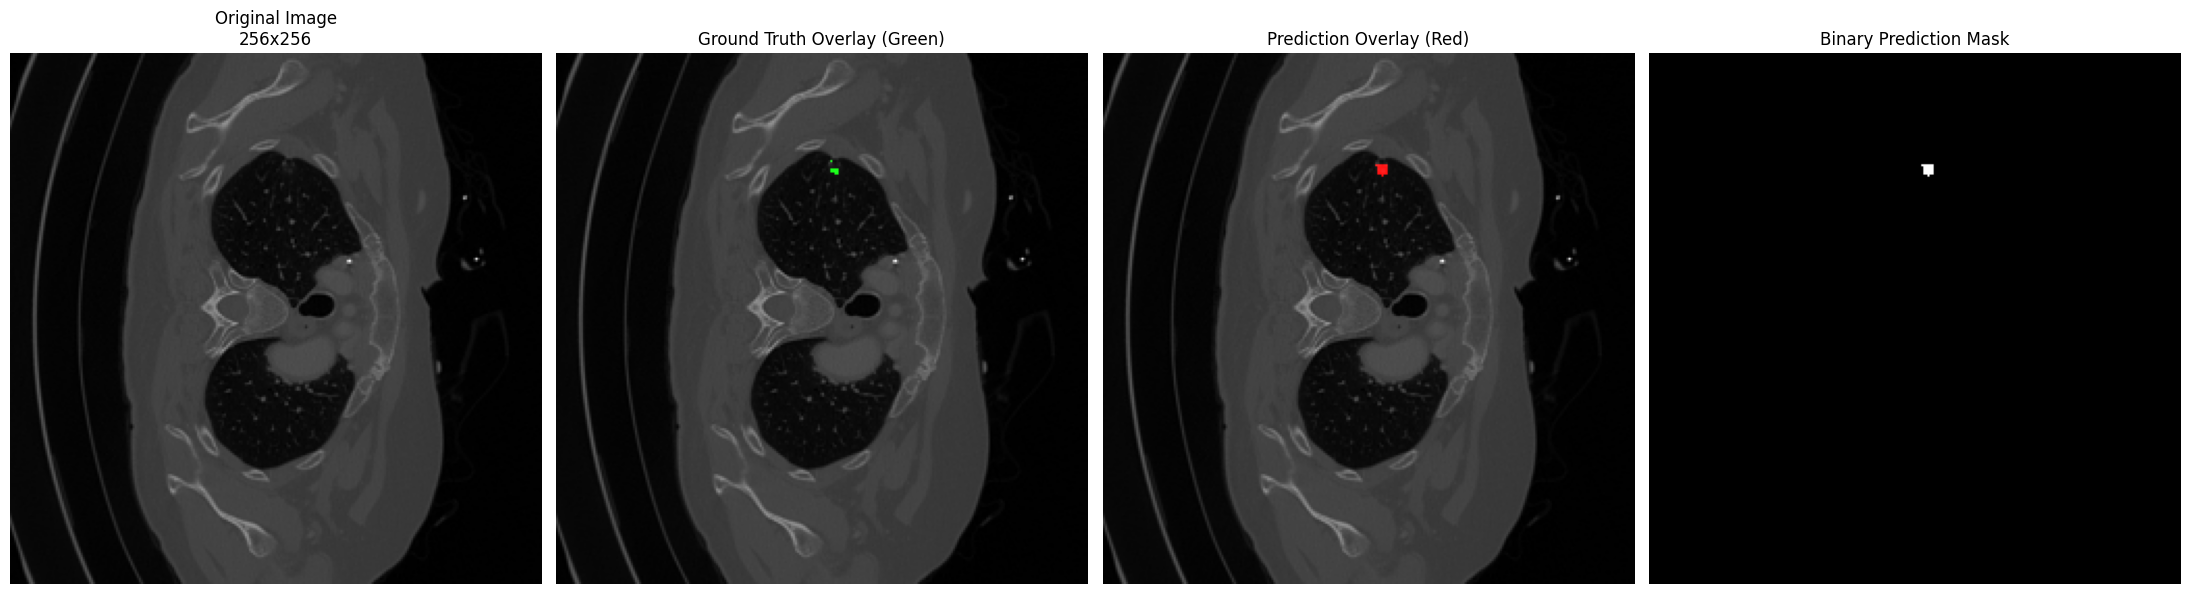

In [32]:
visualize_predictions(model, val_dataset, device, num_samples=5, on_full_image=True)